In [1]:
# This is hardly inspired by the work of Raven Ron on https://www.kaggle.com/codeastar/random-forest-classification-on-talkingdata

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import statsmodels.api as sm
import statsmodels.formula.api as smf

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
import seaborn as sns
import pickle
import itertools
%matplotlib inline

import os
# print(os.listdir("../input"))

import gc, time

dtypes = {
        'ip'            : 'uint32',
        'app'           : 'uint16',
        'device'        : 'uint16',
        'os'            : 'uint16',
        'channel'       : 'uint16',
        'is_attributed' : 'uint8',
        'days'          : 'uint8',
        'hours'         : 'uint8',
        'minutes'       : 'uint8',
        'seconds'       : 'uint8',
        }

# Correcting path to data inside EMAp servers
path = '~/Kaggle/Dados/'

train_columns = ['ip', 'app', 'device', 'os', 'channel', 'is_attributed', 'days', 'hours', 'minutes','seconds']

/usr/local/lib/python3.5/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
# Importing data

# Load training df (partly)
start_time = time.time()
df_train = pd.read_csv(path + '10_train_timed.csv', dtype=dtypes, usecols=train_columns)
print('Load df_train with {} seconds'.format(round(time.time() - start_time, 3)))

Load df_train with 50.835 seconds


In [3]:
# Load testing df
start_time = time.time()
df_test = pd.read_csv(path + 'test_timed.csv', dtype=dtypes)
print('Load df_test with {} seconds'.format(round(time.time() - start_time, 3)))

train_record_index = df_train.shape[0]

Load df_test with 23.247 seconds


In [4]:
df_train.head()

,ip,app,device,os,channel,days,hours,minutes,seconds,is_attributed
0,29045,64,1,13,459,6,14,54,59,0
1,64886,3,1,13,379,6,15,5,17,0
2,147605,3,1,19,379,6,15,8,24,0
3,108881,3,1,19,379,6,15,25,15,0
4,116013,3,1,13,379,6,15,39,18,0


In [5]:
df_test.head()

,click_id,ip,app,device,os,channel,days,hours,minutes,seconds
0,0,5744,9,1,3,107,10,4,0,0
1,1,119901,9,1,3,466,10,4,0,0
2,2,72287,21,1,19,128,10,4,0,0
3,3,78477,15,1,13,111,10,4,0,0
4,4,123080,12,1,13,328,10,4,0,0


In [6]:
#df for submit
df_submit = pd.DataFrame()
df_submit['click_id'] = df_test['click_id']

#Extracting learning data
Learning_Y = df_train['is_attributed']
print('Training target correctly extracted.')

#drop zone
df_test = df_test.drop(['click_id'], axis=1)
df_train = df_train.drop(['is_attributed'], axis=1)
gc.collect();

df_merge = pd.concat([df_train, df_test])
del df_train, df_test
gc.collect();
print('Data was correctly merged')

Training target correctly extracted.
Data was correctly merged


# Primeira tentativa de feature 

contagem de cliques de todos os dados categóricos

In [7]:
# Count all features except device and timestamp data for both train and test df 
start_time = time.time()
columns = df_merge.columns
columns = [i for i in columns if i != 'device' and i != 'days' and i != 'hours' and i != 'minutes'
          and i != 'seconds']

for col in columns:
    df_count = df_merge[col].value_counts().reset_index(name=col+'_count')
    df_count.columns = [col, col+'_count']

    df_merge = df_merge.merge(df_count, on=col, how='left', sort=False)
    df_merge[col+'_count'] = df_merge[col+'_count'].astype('uint16')

    del df_count
    
print('Loaded counts for all features with {} seconds'.format(round(time.time() - start_time, 3)))

Loaded counts for all features with 80.936 seconds


In [8]:
df_merge.head()

,ip,app,device,os,channel,days,hours,minutes,seconds,ip_count,app_count,os_count,channel_count
0,29045,64,1,13,459,6,14,54,59,1472,58544,8424,55595
1,64886,3,1,13,379,6,15,5,17,1702,18901,8424,24734
2,147605,3,1,19,379,6,15,8,24,559,18901,32993,24734
3,108881,3,1,19,379,6,15,25,15,19887,18901,32993,24734
4,116013,3,1,13,379,6,15,39,18,948,18901,8424,24734


In [9]:
gc.collect();

df_train = df_merge[:train_record_index]
df_test = df_merge[train_record_index:]

In [10]:
from sklearn import model_selection
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import average_precision_score

from sklearn.ensemble import RandomForestClassifier
from imblearn.under_sampling import RandomUnderSampler

from matplotlib.font_manager import FontProperties
import seaborn as sns
import pickle
import itertools
%matplotlib inline

import statsmodels.api as sm
import statsmodels.formula.api as smf

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    plt.imshow(cm, interpolation='nearest', cmap=cmap, aspect='auto')
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def clf_eval(clf, X, y_true, classes=['Não baixou', 'Baixou'], normalize=False):
    y_pred = clf.predict(X)
    clf_matrix = confusion_matrix(y_true, y_pred)
    print('Classification Report')
    print(classification_report(y_true, y_pred, target_names=classes))
    print('ROC Score: {}'.format(roc_auc_score(y_true, y_pred)))
    print('Accuracy Score: {}'.format(accuracy_score(y_true, y_pred)))
    print('Average Precision Score: {}'.format(average_precision_score(y_true, y_pred)))
    print('f1 Score: {}'.format(f1_score(y_true, y_pred)))
    plot_confusion_matrix(clf_matrix, classes=classes, normalize=normalize)
    
    return roc_auc_score(y_true, y_pred)

In [11]:
# Doing undersampling

rus = RandomUnderSampler(return_indices=True)
X_resampled, Y_resampled, idx_resampled = rus.fit_sample(df_train, Learning_Y)

X_resampled = pd.DataFrame(X_resampled, columns=df_train.columns)
Y_resampled = pd.DataFrame(Y_resampled, columns=['is_attributed'])


In [12]:
# Separating 10 groups of testing and training for cross validation

train_idx = np.array([])
test_idx = np.array([])
roc_counts = []

idx = model_selection.StratifiedKFold(n_splits=10).split(X_resampled, Y_resampled)

In [13]:
for train_idx, test_idx in idx:
    start_time = time.time()
    X = X_resampled.iloc[train_idx]
    Y = Y_resampled.iloc[train_idx]
    rf = RandomForestClassifier(n_estimators=13, max_depth=13, verbose=0, n_jobs = -1)
    rf = rf.fit(X, Y.values.ravel())
    
    print('RandomForest has fitted X_resampled with {} seconds'.format(round(time.time() - start_time), 3))
        
    Y_true = Y_resampled.iloc[test_idx]
    Y_pred = rf.predict(X_resampled.iloc[test_idx])
    roc_counts.append(roc_auc_score(Y_true, Y_pred))

RandomForest has fitted X_resampled with 1 seconds
RandomForest has fitted X_resampled with 1 seconds
RandomForest has fitted X_resampled with 0 seconds
RandomForest has fitted X_resampled with 0 seconds
RandomForest has fitted X_resampled with 0 seconds
RandomForest has fitted X_resampled with 0 seconds
RandomForest has fitted X_resampled with 0 seconds
RandomForest has fitted X_resampled with 0 seconds
RandomForest has fitted X_resampled with 0 seconds
RandomForest has fitted X_resampled with 0 seconds


Text(0.5,1,'Models ROC Scores')

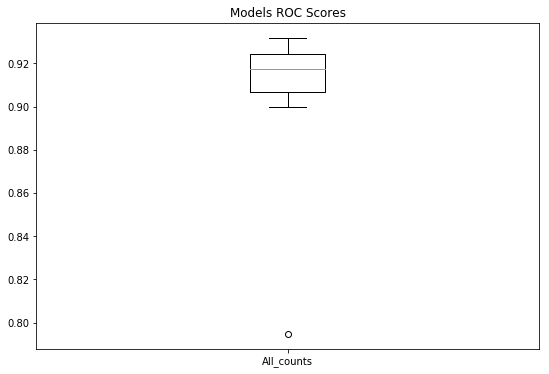

In [27]:
# Ploting the ROC scores
roc_counts = np.array(roc_counts)

fig = plt.figure(1, figsize=(9, 6))
ax = fig.add_subplot(111)

ax.boxplot(roc_counts)
ax.set_xticklabels(['All_counts'])
ax.set_title('Models ROC Scores')

Usando só o IP counts

In [54]:
# Doing undersampling

params = ['ip', 'app', 'device', 'os', 'channel','days', 'hours', 'minutes',
                                                                  'seconds', 'ip_count']
rus = RandomUnderSampler(return_indices=True)
X_resampled, Y_resampled, idx_resampled = rus.fit_sample(df_train[params], Learning_Y)

X_resampled = pd.DataFrame(X_resampled, columns=params)
Y_resampled = pd.DataFrame(Y_resampled, columns=['is_attributed'])

In [55]:
# Separating 10 groups of testing and training for cross validation

train_idx = np.array([])
test_idx = np.array([])
roc_ipcounts = []

idx = model_selection.StratifiedKFold(n_splits=10).split(X_resampled, Y_resampled)

In [56]:
for train_idx, test_idx in idx:
    start_time = time.time()
    X = X_resampled.iloc[train_idx]
    Y = Y_resampled.iloc[train_idx]
    rf = RandomForestClassifier(n_estimators=13, max_depth=13, verbose=0, n_jobs = -1)
    rf = rf.fit(X, Y.values.ravel())
    
    print('RandomForest has fitted X_resampled with {} seconds'.format(round(time.time() - start_time), 3))
        
    Y_true = Y_resampled.iloc[test_idx]
    Y_pred = rf.predict(X_resampled.iloc[test_idx])
    roc_ipcounts.append(roc_auc_score(Y_true, Y_pred))

RandomForest has fitted X_resampled with 0 seconds
RandomForest has fitted X_resampled with 0 seconds
RandomForest has fitted X_resampled with 0 seconds
RandomForest has fitted X_resampled with 0 seconds
RandomForest has fitted X_resampled with 0 seconds
RandomForest has fitted X_resampled with 0 seconds
RandomForest has fitted X_resampled with 0 seconds
RandomForest has fitted X_resampled with 0 seconds
RandomForest has fitted X_resampled with 0 seconds
RandomForest has fitted X_resampled with 0 seconds


Text(0.5,1,'Models ROC Scores')

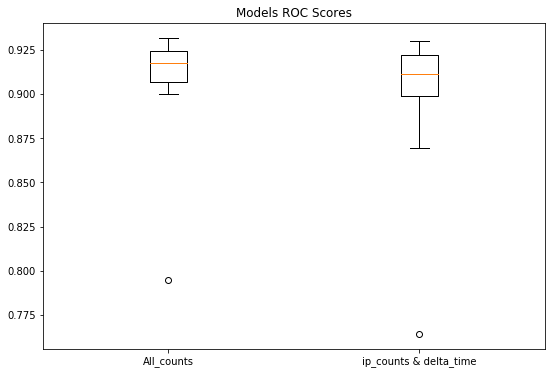

In [57]:
# Ploting the ROC scores
roc_ipcounts = np.array(roc_ipcounts)
data_plot = [roc_counts, roc_ipcounts]
lables = ['All_counts', 'ip_counts']

fig = plt.figure(1, figsize=(9, 6))
ax = fig.add_subplot(111)

ax.boxplot(data_plot)
ax.set_xticklabels(labels)
ax.set_title('Models ROC Scores')

# Segunda tentativa

Acrescentando diferença de clique time

In [28]:
# This cell takes a long time to run.... be pacient
start_time = time.time()
gr = pd.DataFrame()
gr['ip'] = df_merge.ip
gr['time'] = pd.to_datetime(df_merge.loc[:,['hours', 'minutes', 'seconds']].astype(str).apply(''.join,1),format='%H%M%S')
temp = gr.groupby('ip', as_index=False)).time.diff().dt.total_seconds()
print('New dataframe with diff clicktime created in {} seconds'.format(round(time.time() - start_time), 3))

1798.308


0   NaN
1   NaN
2   NaN
3   NaN
4   NaN
Name: time, dtype: float64

In [35]:
temp = temp.to_frame()
temp.reset_index(level=1, inplace=True)
temp.columns = ['ip', 'delta_time']
temp.delta_time = abs(temp.delta_time)
temp.delta_time = temp.delta_time.fillna(value=0)

temp.head()

time
0 21380769      NaN
  21526668    163.0
1 12731137      NaN
  12747692  -1576.0
  16683909 -35601.0

In [42]:
#Merging the new feature created in the original df
df_merge = df_merge.merge(temp, on='ip', how='left')

# Deleting the temporary df created on the process
del temp, gr
gc.collect();

df_merge.head()

,ip,app,device,os,channel,days,hours,minutes,seconds,ip_count,app_count,os_count,channel_count,delta_time
0,29045,64,1,13,459,6,14,54,59,1472,58544,8424,55595,0.0
1,64886,3,1,13,379,6,15,5,17,1702,18901,8424,24734,157.0
2,147605,3,1,19,379,6,15,8,24,559,18901,32993,24734,14.0
3,108881,3,1,19,379,6,15,25,15,19887,18901,32993,24734,288.0
4,116013,3,1,13,379,6,15,39,18,948,18901,8424,24734,0.0


In [44]:
# Getting back train and test
df_train = df_merge[:train_record_index]
df_test = df_merge[train_record_index:]

In [45]:
# Doing undersampling
params = ['ip', 'app', 'device', 'os', 'channel','days', 'hours', 'minutes',
                                                                  'seconds', 'ip_count', 'delta_time']
rus = RandomUnderSampler(return_indices=True)
X_resampled, Y_resampled, idx_resampled = rus.fit_sample(df_train[params], Learning_Y)

X_resampled = pd.DataFrame(X_resampled, columns=params)
Y_resampled = pd.DataFrame(Y_resampled, columns=['is_attributed'])

In [48]:
# Separating 10 groups of testing and training for cross validation

train_idx = np.array([])
test_idx = np.array([])
roc_ipcounts_dtime = []

idx = model_selection.StratifiedKFold(n_splits=10).split(X_resampled, Y_resampled)

In [49]:
for train_idx, test_idx in idx:
    start_time = time.time()
    X = X_resampled.iloc[train_idx]
    Y = Y_resampled.iloc[train_idx]
    rf = RandomForestClassifier(n_estimators=13, max_depth=13, verbose=0, n_jobs = -1)
    rf = rf.fit(X, Y.values.ravel())
    
    print('RandomForest has fitted X_resampled with {} seconds'.format(round(time.time() - start_time), 3))
        
    Y_true = Y_resampled.iloc[test_idx]
    Y_pred = rf.predict(X_resampled.iloc[test_idx])
    roc_ipcounts_dtime.append(roc_auc_score(Y_true, Y_pred))

RandomForest has fitted X_resampled with 0 seconds
RandomForest has fitted X_resampled with 1 seconds
RandomForest has fitted X_resampled with 0 seconds
RandomForest has fitted X_resampled with 0 seconds
RandomForest has fitted X_resampled with 0 seconds
RandomForest has fitted X_resampled with 0 seconds
RandomForest has fitted X_resampled with 0 seconds
RandomForest has fitted X_resampled with 0 seconds
RandomForest has fitted X_resampled with 0 seconds
RandomForest has fitted X_resampled with 0 seconds


Text(0.5,1,'Models ROC Scores')

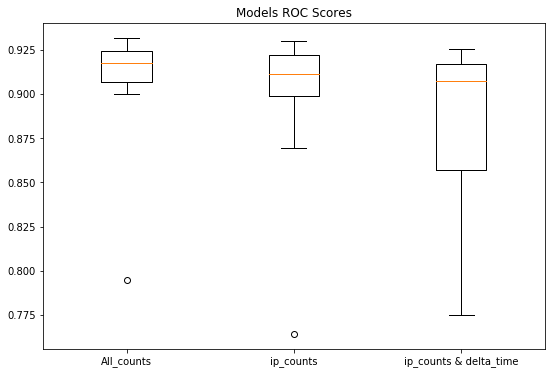

In [58]:
# Ploting the ROC scores
roc_ipcounts_dtime = np.array(roc_ipcounts_dtime)
data_plot = [roc_counts, roc_ipcounts, roc_ipcounts_dtime]
labels = ['All_counts', 'ip_counts', 'ip_counts & delta_time']

fig = plt.figure(1, figsize=(9, 6))
ax = fig.add_subplot(111)

ax.boxplot(data_plot)
ax.set_xticklabels(labels)
ax.set_title('Models ROC Scores')